# Chapter 5: The Many Variables & The Spurious Waffles

**Exploratory Data Analysis: Divorce Rates and Waffle Houses**

## The Question

What predicts divorce rates across US states?

**Candidate predictors:**
- Marriage rate
- Median age at marriage
- Waffle House restaurants per capita (!)

## The Setup: Spurious Associations

This dataset is famous for demonstrating **spurious correlation**:
- Waffle Houses are correlated with divorce rates
- But does eating waffles cause divorce?
- Or is there a **confounding variable**?

**Goal of this notebook:** Explore the data to understand relationships before modeling.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Random seed
np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


---

## Step 1: Load the Data

The WaffleDivorce dataset contains information about US states.

In [2]:
# Load WaffleDivorce data from Statistical Rethinking repository
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
waffle_data = pd.read_csv(url, sep=";")

print(f"Dataset shape: {waffle_data.shape}")
print(f"Number of states: {len(waffle_data)}\n")

# Display first few rows
print("First 5 rows:")
waffle_data.head()

Dataset shape: (50, 13)
Number of states: 50

First 5 rows:


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [3]:
# Column information
print("Column names and types:")
print(waffle_data.dtypes)
print("\nColumn descriptions:")
print(waffle_data.columns.tolist())

Column names and types:
Location              object
Loc                   object
Population           float64
MedianAgeMarriage    float64
Marriage             float64
Marriage SE          float64
Divorce              float64
Divorce SE           float64
WaffleHouses           int64
South                  int64
Slaves1860             int64
Population1860         int64
PropSlaves1860       float64
dtype: object

Column descriptions:
['Location', 'Loc', 'Population', 'MedianAgeMarriage', 'Marriage', 'Marriage SE', 'Divorce', 'Divorce SE', 'WaffleHouses', 'South', 'Slaves1860', 'Population1860', 'PropSlaves1860']


### Key Variables

**Outcome (what we want to predict):**
- `Divorce` - Divorce rate (divorces per 1000 adults)

**Predictors:**
- `Marriage` - Marriage rate (marriages per 1000 adults)
- `MedianAgeMarriage` - Median age at marriage
- `WaffleHouses` - Number of Waffle House restaurants (per million residents)

---

## Step 2: Basic Statistics

Let's understand the distributions of our variables.

In [4]:
# Summary statistics for key variables
key_vars = ['Divorce', 'Marriage', 'MedianAgeMarriage', 'WaffleHouses']

print("Summary Statistics:")
print("="*70)
waffle_data[key_vars].describe().round(2)

Summary Statistics:


,Divorce,Marriage,MedianAgeMarriage,WaffleHouses
count,50.00,50.00,50.00,50.00
mean,9.69,20.11,26.05,32.34
std,1.82,3.80,1.24,65.79
min,6.10,13.50,23.20,0.00
25%,8.30,17.12,25.32,0.00
50%,9.75,19.70,25.90,1.00
75%,10.90,22.10,26.75,39.75
max,13.50,30.70,29.70,381.00


In [5]:
# Check for missing values
print("Missing values:")
print(waffle_data[key_vars].isnull().sum())

if waffle_data[key_vars].isnull().sum().sum() == 0:
    print("\n✓ No missing values!")
else:
    print("\n⚠️ Some missing values present")

Missing values:
Divorce              0
Marriage             0
MedianAgeMarriage    0
WaffleHouses         0
dtype: int64

✓ No missing values!


---

## Step 3: Distribution of Variables

Let's visualize the distribution of each variable.

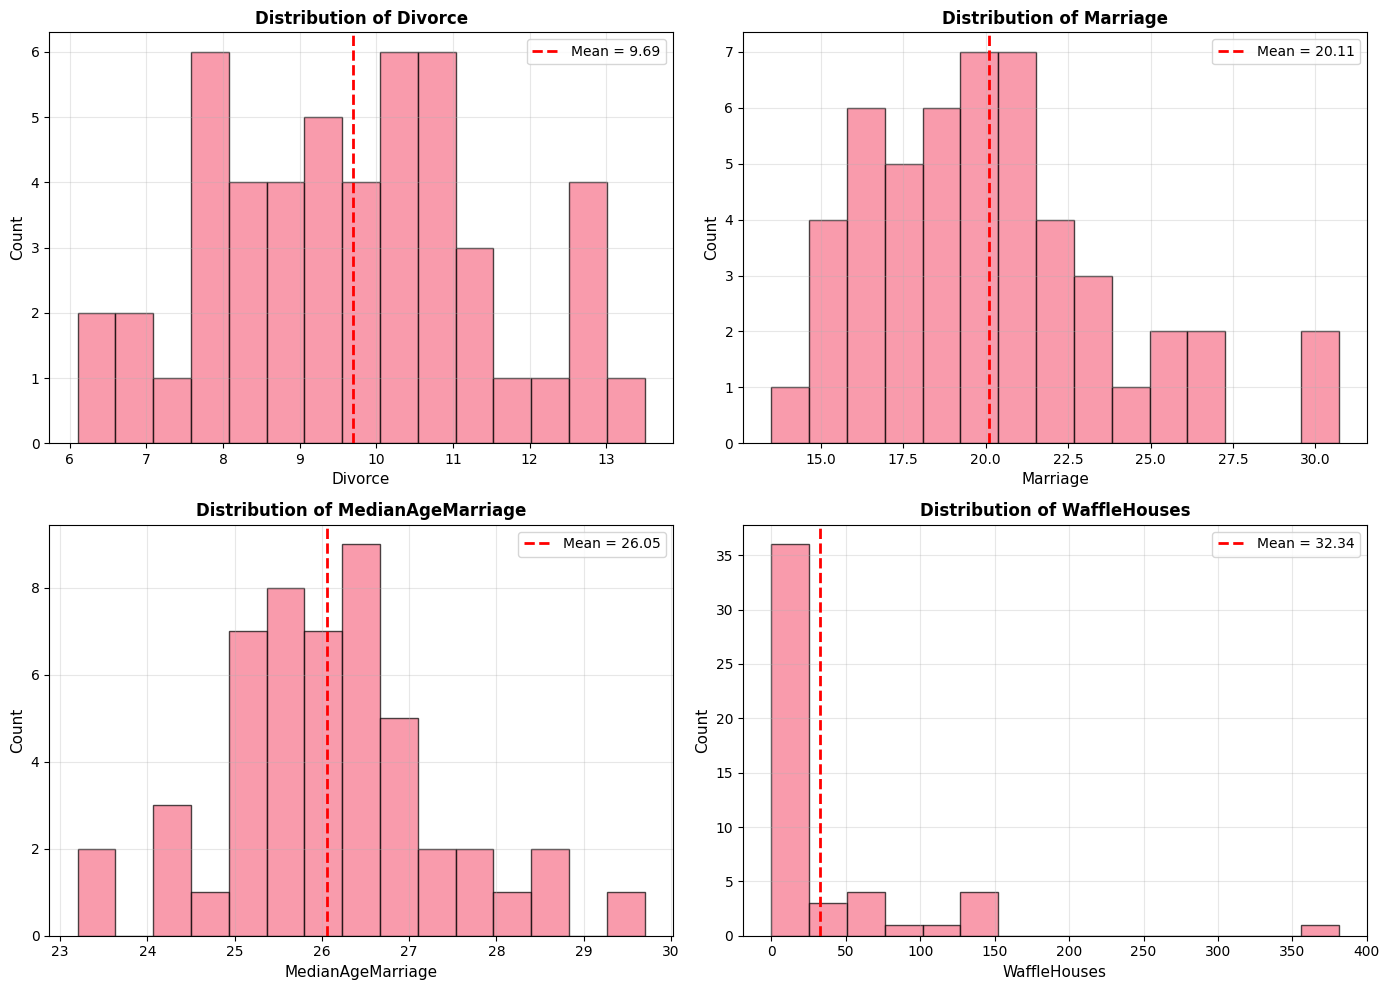

Observations:
• All variables appear roughly symmetric
• No obvious outliers
• WaffleHouses is right-skewed (many states have 0)


In [6]:
# Histograms for all key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, var in enumerate(key_vars):
    ax = axes[idx]
    
    # Histogram
    ax.hist(waffle_data[var], bins=15, edgecolor='black', alpha=0.7)
    
    # Add mean line
    mean_val = waffle_data[var].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Mean = {mean_val:.2f}')
    
    # Labels
    ax.set_xlabel(var, fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("• All variables appear roughly symmetric")
print("• No obvious outliers")
print("• WaffleHouses is right-skewed (many states have 0)")

---

## Step 4: Bivariate Relationships

**Key question:** How does each predictor relate to divorce rate?

Let's create scatter plots to visualize these relationships.

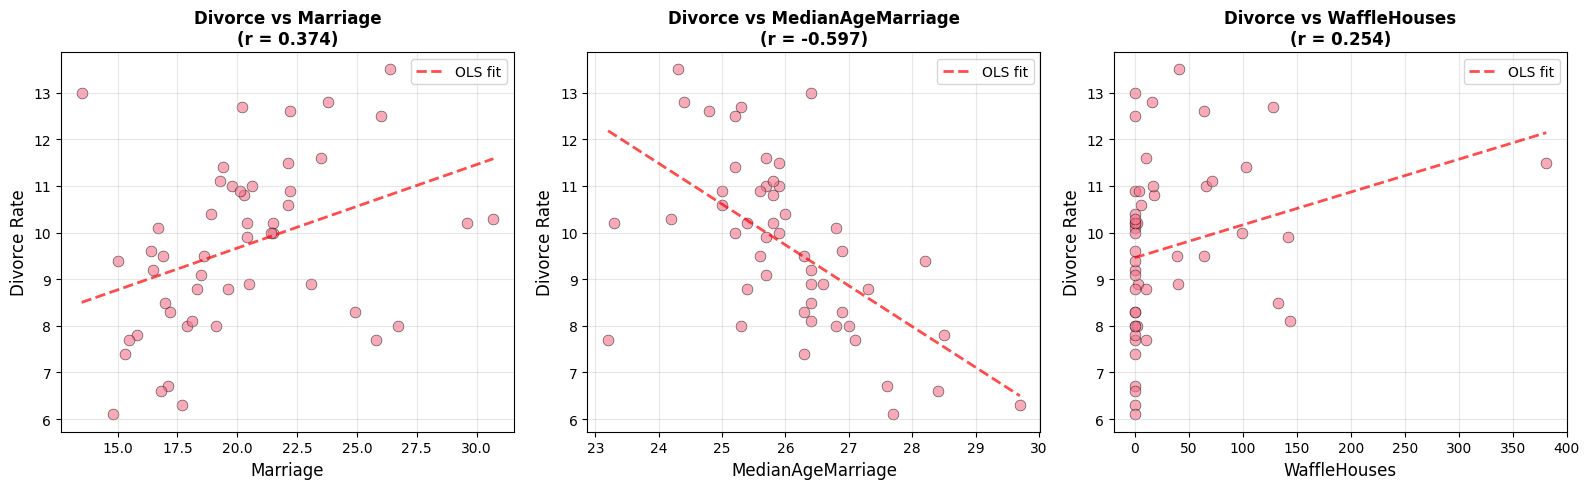

Key Observations:
• Marriage rate: POSITIVE correlation with divorce
• Median age: NEGATIVE correlation with divorce
• Waffle Houses: POSITIVE correlation with divorce (!)


In [7]:
# Scatter plots: Each predictor vs Divorce
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

predictors = ['Marriage', 'MedianAgeMarriage', 'WaffleHouses']

for idx, pred in enumerate(predictors):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(waffle_data[pred], waffle_data['Divorce'], 
               alpha=0.6, s=60, edgecolor='black', linewidth=0.5)
    
    # Add best fit line (OLS for visualization only)
    slope, intercept = np.polyfit(waffle_data[pred], waffle_data['Divorce'], 1)
    x_line = np.array([waffle_data[pred].min(), waffle_data[pred].max()])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7, label='OLS fit')
    
    # Calculate correlation
    corr = waffle_data[[pred, 'Divorce']].corr().iloc[0, 1]
    
    # Labels
    ax.set_xlabel(pred, fontsize=12)
    ax.set_ylabel('Divorce Rate', fontsize=12)
    ax.set_title(f'Divorce vs {pred}\n(r = {corr:.3f})', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("• Marriage rate: POSITIVE correlation with divorce")
print("• Median age: NEGATIVE correlation with divorce")
print("• Waffle Houses: POSITIVE correlation with divorce (!)")

### The Waffle House Paradox

**Observation:** States with more Waffle Houses have higher divorce rates!

**But wait...** Does this mean:
1. Eating waffles causes divorce?
2. Getting divorced makes you crave waffles?
3. Or... there's a **confounding variable**?

**Spoiler alert:** Waffle Houses are concentrated in the South. Southern states also tend to have:
- Younger marriage ages → Higher divorce rates
- More Waffle Houses

**This is a spurious correlation!** We'll prove this with multiple regression.

---

## Step 5: Correlation Matrix

Let's look at **all pairwise correlations** to understand the relationships between predictors.

In [8]:
# Correlation matrix
corr_matrix = waffle_data[key_vars].corr()

print("Correlation Matrix:")
print("="*70)
print(corr_matrix.round(3))

Correlation Matrix:
                   Divorce  Marriage  MedianAgeMarriage  WaffleHouses
Divorce              1.000     0.374             -0.597         0.254
Marriage             0.374     1.000             -0.721         0.027
MedianAgeMarriage   -0.597    -0.721              1.000        -0.118
WaffleHouses         0.254     0.027             -0.118         1.000


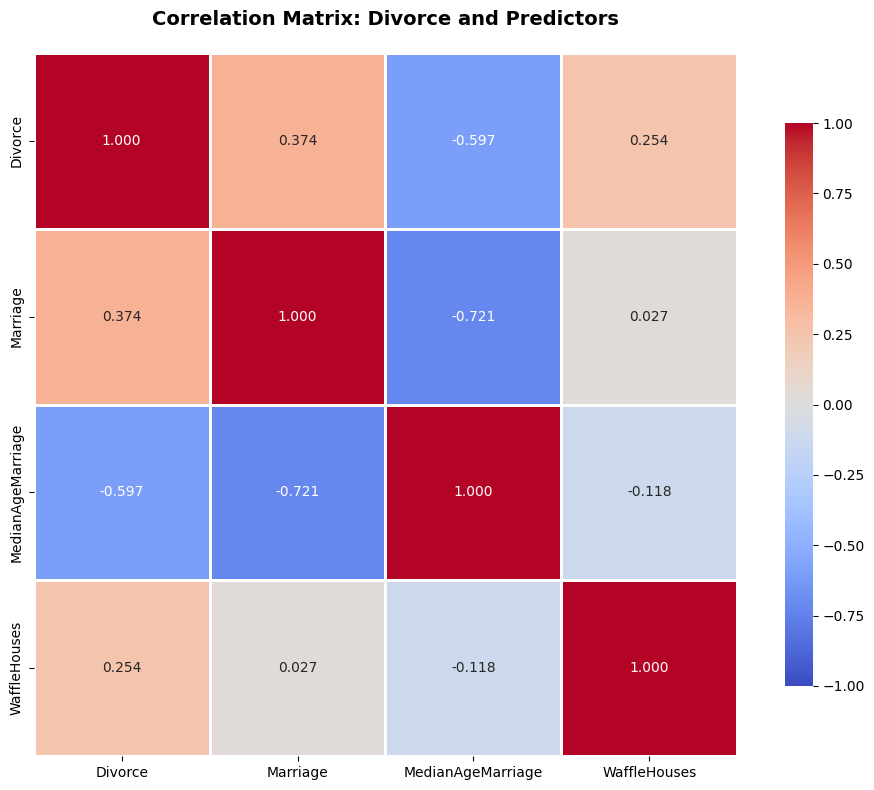


Key Correlations with Divorce:
  Marriage            :  0.374
  WaffleHouses        :  0.254
  MedianAgeMarriage   : -0.597


In [9]:
# Visualize correlation matrix as heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix: Divorce and Predictors', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlations with Divorce:")
print("="*70)
divorce_corrs = corr_matrix['Divorce'].drop('Divorce').sort_values(ascending=False)
for var, corr in divorce_corrs.items():
    print(f"  {var:20s}: {corr:6.3f}")

### Critical Observation

**Predictors are correlated with each other!**

- Marriage rate ↔ Median age: Probably correlated
- Waffle Houses ↔ Median age: Likely correlated (Southern states)

**This is why we need multiple regression!**

When predictors are correlated:
- Simple regression can be misleading
- Coefficients change when you add more predictors
- Need to account for **confounding**

---

## Step 6: Geographic Patterns

Let's identify which states have extreme values.

In [10]:
# States with highest/lowest divorce rates
print("States with HIGHEST Divorce Rates:")
print("="*70)
print(waffle_data.nlargest(5, 'Divorce')[['Location', 'Divorce', 'Marriage', 'MedianAgeMarriage', 'WaffleHouses']])

print("\nStates with LOWEST Divorce Rates:")
print("="*70)
print(waffle_data.nsmallest(5, 'Divorce')[['Location', 'Divorce', 'Marriage', 'MedianAgeMarriage', 'WaffleHouses']])

States with HIGHEST Divorce Rates:
    Location  Divorce  Marriage  MedianAgeMarriage  WaffleHouses
3   Arkansas     13.5      26.4               24.3            41
19     Maine     13.0      13.5               26.4             0
35  Oklahoma     12.8      23.8               24.4            16
0    Alabama     12.7      20.2               25.3           128
17  Kentucky     12.6      22.2               24.8            64

States with LOWEST Divorce Rates:
                Location  Divorce  Marriage  MedianAgeMarriage  WaffleHouses
29            New Jersey      6.1      14.8               27.7             0
8   District of Columbia      6.3      17.7               29.7             0
31              New York      6.6      16.8               28.4             0
6            Connecticut      6.7      17.1               27.6             0
23             Minnesota      7.4      15.3               26.3             0


In [11]:
# States with most/fewest Waffle Houses
print("\nStates with MOST Waffle Houses:")
print("="*70)
print(waffle_data.nlargest(5, 'WaffleHouses')[['Location', 'Divorce', 'Marriage', 'MedianAgeMarriage', 'WaffleHouses']])

print("\nStates with NO Waffle Houses:")
print("="*70)
no_waffles = waffle_data[waffle_data['WaffleHouses'] == 0]
print(f"Number of states: {len(no_waffles)}")
print(no_waffles[['Location', 'Divorce', 'MedianAgeMarriage']].head(10))


States with MOST Waffle Houses:
          Location  Divorce  Marriage  MedianAgeMarriage  WaffleHouses
10         Georgia     11.5      22.1               25.9           381
39  South Carolina      8.1      18.1               26.4           144
32  North Carolina      9.9      20.4               25.7           142
9          Florida      8.5      17.0               26.4           133
0          Alabama     12.7      20.2               25.3           128

States with NO Waffle Houses:
Number of states: 25
                Location  Divorce  MedianAgeMarriage
1                 Alaska     12.5               25.2
4             California      8.0               26.8
6            Connecticut      6.7               27.6
8   District of Columbia      6.3               29.7
11                Hawaii      8.3               26.9
12                 Idaho      7.7               23.2
15                  Iowa     10.2               25.4
19                 Maine     13.0               26.4
21         M

---

## Step 7: Standardize Variables

Before modeling, let's **standardize** all variables:

$$x_{std} = \frac{x - \bar{x}}{\text{sd}(x)}$$

**Why?**
1. Puts all variables on same scale
2. Makes coefficients comparable
3. Easier to set priors
4. Numerical stability

In [12]:
# Create standardized versions
waffle_std = waffle_data.copy()

for var in key_vars:
    mean_val = waffle_data[var].mean()
    std_val = waffle_data[var].std()
    waffle_std[f'{var}_std'] = (waffle_data[var] - mean_val) / std_val
    
    print(f"{var:20s}: mean = {mean_val:6.2f}, std = {std_val:6.2f}")

# Verify standardization
print("\nStandardized variables (should have mean≈0, std≈1):")
print("="*70)
std_vars = [f'{v}_std' for v in key_vars]
print(waffle_std[std_vars].describe().round(3))

Divorce             : mean =   9.69, std =   1.82
Marriage            : mean =  20.11, std =   3.80
MedianAgeMarriage   : mean =  26.05, std =   1.24
WaffleHouses        : mean =  32.34, std =  65.79

Standardized variables (should have mean≈0, std≈1):
       Divorce_std  Marriage_std  MedianAgeMarriage_std  WaffleHouses_std
count       50.000        50.000                 50.000            50.000
mean        -0.000        -0.000                  0.000            -0.000
std          1.000         1.000                  1.000             1.000
min         -1.971        -1.741                 -2.295            -0.492
25%         -0.762        -0.787                 -0.586            -0.492
50%          0.034        -0.109                 -0.124            -0.476
75%          0.666         0.523                  0.560             0.113
max          2.094         2.787                  2.932             5.300


In [13]:
# Save standardized data for modeling
# We'll use this in the next notebooks
print("✓ Standardized data ready for modeling")
print(f"  Variables: {std_vars}")
print(f"  Shape: {waffle_std.shape}")

✓ Standardized data ready for modeling
  Variables: ['Divorce_std', 'Marriage_std', 'MedianAgeMarriage_std', 'WaffleHouses_std']
  Shape: (50, 17)


---

## Step 8: Standardization Preserves Geometry

**Key insight:** Standardization is just a linear transformation (rescaling). It changes **units** but NOT **geometry**.

Let's verify that OLS relationships remain unchanged after standardization.

### What STAYS the same:
- Correlation coefficients
- R² (proportion of variance explained)
- Shape of scatter plots
- Statistical significance

### What CHANGES:
- Slope (different units)
- Intercept (different units)

---

In [14]:
# Compare OLS on original vs standardized data
# Let's use Age → Divorce as an example

# Original scale
age_orig = waffle_data['MedianAgeMarriage'].values
divorce_orig = waffle_data['Divorce'].values

slope_orig, intercept_orig = np.polyfit(age_orig, divorce_orig, 1)
r_squared_orig = np.corrcoef(age_orig, divorce_orig)[0, 1]**2
corr_orig = np.corrcoef(age_orig, divorce_orig)[0, 1]

# Standardized scale
age_std = waffle_std['MedianAgeMarriage_std'].values
divorce_std = waffle_std['Divorce_std'].values

slope_std, intercept_std = np.polyfit(age_std, divorce_std, 1)
r_squared_std = np.corrcoef(age_std, divorce_std)[0, 1]**2
corr_std = np.corrcoef(age_std, divorce_std)[0, 1]

# Display comparison
print("OLS Regression: Divorce ~ MedianAgeMarriage")
print("="*70)
print("\n                    ORIGINAL SCALE    STANDARDIZED SCALE")
print("-"*70)
print(f"Slope:              {slope_orig:14.4f}    {slope_std:14.4f}")
print(f"Intercept:          {intercept_orig:14.4f}    {intercept_std:14.4f}")
print(f"Correlation (r):    {corr_orig:14.4f}    {corr_std:14.4f}  ← SAME!")
print(f"R²:                 {r_squared_orig:14.4f}    {r_squared_std:14.4f}  ← SAME!")
print("="*70)

print("\n✓ Correlation and R² are IDENTICAL!")
print("✓ Only slope/intercept changed (due to unit changes)")

OLS Regression: Divorce ~ MedianAgeMarriage

                    ORIGINAL SCALE    STANDARDIZED SCALE
----------------------------------------------------------------------
Slope:                     -0.8744           -0.5972
Intercept:                 32.4703            0.0000
Correlation (r):           -0.5972           -0.5972  ← SAME!
R²:                         0.3567            0.3567  ← SAME!

✓ Correlation and R² are IDENTICAL!
✓ Only slope/intercept changed (due to unit changes)


### Visual Comparison: Original vs Standardized

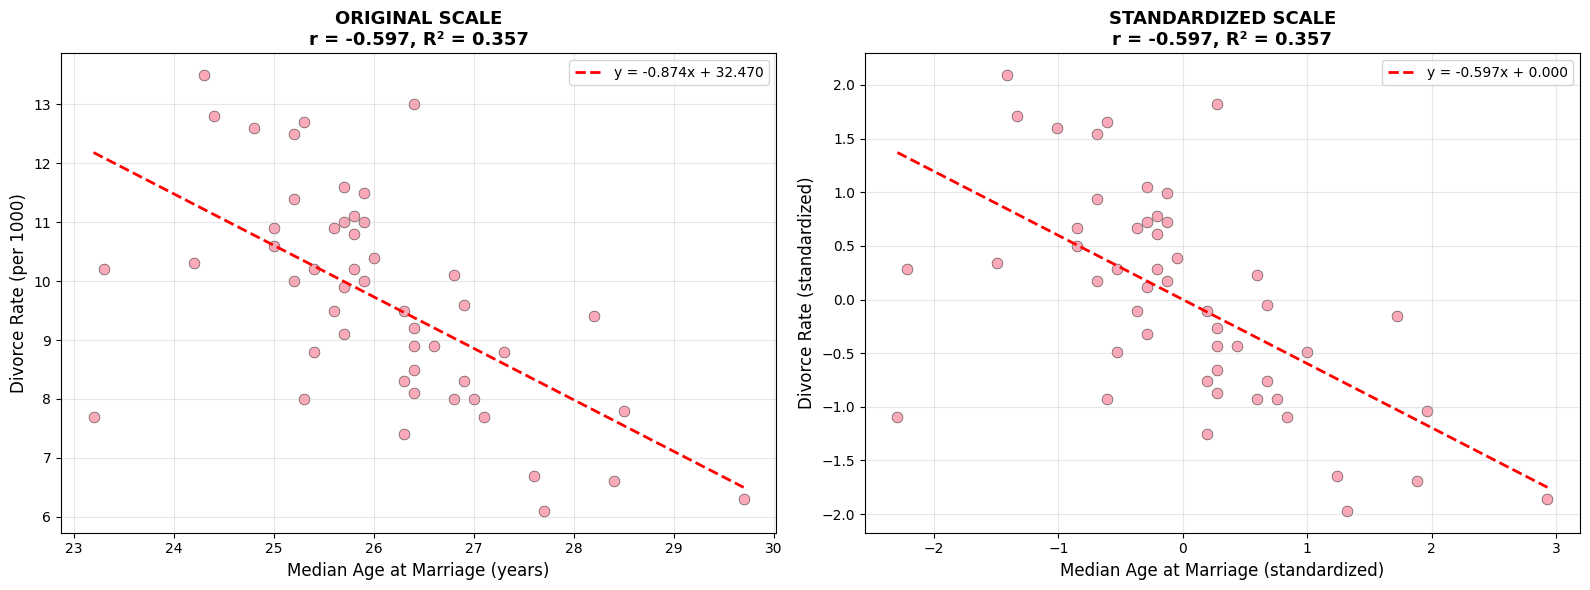

Observations:
• SAME shape, SAME correlation, SAME R²
• Different axis labels (units changed)
• Different slope/intercept values (but same relationship!)
• Standardization preserves the GEOMETRY of the data


In [15]:
# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original scale
ax = axes[0]
ax.scatter(age_orig, divorce_orig, alpha=0.6, s=60, edgecolor='black', linewidth=0.5)

x_line_orig = np.linspace(age_orig.min(), age_orig.max(), 100)
y_line_orig = slope_orig * x_line_orig + intercept_orig
ax.plot(x_line_orig, y_line_orig, 'r--', linewidth=2, label=f'y = {slope_orig:.3f}x + {intercept_orig:.3f}')

ax.set_xlabel('Median Age at Marriage (years)', fontsize=12)
ax.set_ylabel('Divorce Rate (per 1000)', fontsize=12)
ax.set_title(f'ORIGINAL SCALE\nr = {corr_orig:.3f}, R² = {r_squared_orig:.3f}',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Standardized scale
ax = axes[1]
ax.scatter(age_std, divorce_std, alpha=0.6, s=60, edgecolor='black', linewidth=0.5)

x_line_std = np.linspace(age_std.min(), age_std.max(), 100)
y_line_std = slope_std * x_line_std + intercept_std
ax.plot(x_line_std, y_line_std, 'r--', linewidth=2, label=f'y = {slope_std:.3f}x + {intercept_std:.3f}')

ax.set_xlabel('Median Age at Marriage (standardized)', fontsize=12)
ax.set_ylabel('Divorce Rate (standardized)', fontsize=12)
ax.set_title(f'STANDARDIZED SCALE\nr = {corr_std:.3f}, R² = {r_squared_std:.3f}',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("• SAME shape, SAME correlation, SAME R²")
print("• Different axis labels (units changed)")
print("• Different slope/intercept values (but same relationship!)")
print("• Standardization preserves the GEOMETRY of the data")

---

## Summary: What We Learned

### The Data

- **50 US states**
- **Outcome:** Divorce rate (divorces per 1000 adults)
- **Predictors:** Marriage rate, Median age at marriage, Waffle Houses per capita

### Key Findings

1. **Divorce rate varies across states** (from ~6 to ~14 per 1000)

2. **Three predictors, all correlated with divorce:**
   - Marriage rate: Positive correlation
   - Median age: Negative correlation (younger marriage → more divorce)
   - Waffle Houses: Positive correlation (!)

3. **Predictors are correlated with EACH OTHER**
   - This creates confounding
   - Simple regression can be misleading
   - Need multiple regression to disentangle effects

4. **The Waffle House paradox:**
   - Spurious correlation (likely)
   - Confounded by region/culture
   - We'll test this with multiple regression!

### Next Steps

**Notebook 2: Single Predictor Models**
- Fit separate models for each predictor
- Understand bivariate relationships
- Establish baseline before multiple regression

**Notebook 3: Multiple Regression**
- Include multiple predictors simultaneously
- See how coefficients change
- Expose the spurious waffle association!

---

**Key Takeaway:** When predictors are correlated, you need multiple regression to understand causal relationships. Simple correlations can be misleading!